In [1]:
from fastai.model import *
from fastai.dataset import *
from fastai.conv_learner import *
from utils.clr import *
from pathlib import Path
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
%matplotlib inline
%reload_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'fastai.model'

In [4]:
PATH = Path("../data/mnist")

In [5]:
params = {"bs":16,
         "sz": 28,
         "t_pc": 1,
         "epochs": 7,
         "lr": 2e-3}

In [6]:
df = pd.read_csv(PATH/"train.csv")

FileNotFoundError: File b'../data/mnist/train.csv' does not exist

In [6]:
imgs = df[:int(len(df)*params["t_pc"])].drop("label", axis =1)
imgs = imgs/255.0
val_idxs = get_cv_idxs(len(imgs))
((x_val, x_train),) = split_by_idx(val_idxs, imgs)

In [7]:
x_val = x_val.values.reshape(-1,1,params["sz"],params["sz"])
x_train = x_train.values.reshape(-1,1,params["sz"],params["sz"])

In [8]:
md = ImageClassifierData.from_arrays(PATH, (x_train, x_train), (x_val, x_val), bs=params["bs"])

In [9]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stri=2, kern=4, pad=1, drop=0.1, relu=True):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, kernel_size=kern, stride=stri, padding=pad,bias=False)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        self.relu = relu
    def forward(self, x):
        if self.relu:
            return self.drop(self.bn(F.relu(self.conv(x))))
        else:
            return self.drop(self.bn(self.conv(x)))
        
class StdUpsample(nn.Module):
    def __init__(self, nin, nout,kern=2,stri=2, pad=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, kern, stri, padding=pad)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))
    
class StdLinear(nn.Module):
    def __init__(self, nin, nout, relu=True):
        super().__init__()
        self.lin = nn.Linear(nin, nout)
        self.relu = relu
    def forward(self, x):
        if self.relu: return F.relu(self.lin(x))
        return self.lin(x)

In [30]:
#https://github.com/nakosung/VQ-VAE/blob/master/model.py
#https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb

class VectorQuant(nn.Module):
    def __init__(self, num_emb, emb_dim, comm_cost):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_emb = num_emb
        self.emb = nn.Embedding(self.num_emb, self.emb_dim)
        self.emb.weight.data.uniform_(-1/self.num_emb, 1/self.num_emb)
        self.comm_cost = comm_cost
        
    def forward(self, x):
        x = x.permute(0,2,3,1).contiguous()
        x_sz = x.shape
        
        flat = x.view(-1, self.emb_dim)
        
        dist = (torch.sum(flat**2, dim=1, keepdim=True) + torch.sum(self.emb.weight**2, dim=1)
            - 2 * torch.matmul(flat, self.emb.weight.t()))
        
        enc_idxs = torch.argmin(dist, dim=1).unsqueeze(1)
        encs = torch.zeros(enc_idxs.shape[0], self.num_emb).cuda()
        encs.scatter_(1,enc_idxs,1)
        
        quant = torch.matmul(encs, self.emb.weight).view(x_sz)
        
        e_lat_loss = torch.mean((quant.detach()-x)**2)
        q_lat_loss = torch.mean((quant-x.detach())**2)
        loss = q_lat_loss + self.comm_cost * e_lat_loss
        
        quant = x + (quant - x).detach()
        avg_probs = torch.mean(encs, dim =0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return quant.permute(0,3,1,2).contiguous(), loss, perplexity, encs

class VQ_CVAE(nn.Module):
    def __init__(self, n_latent, commit_coef=.25, vae=False):
        super().__init__()
        self.vae = vae
        self.n_latent = n_latent
        self.lat_chan = l_c = 64
        self.z_dim = 28//2**2
        self.h_dim = self.lat_chan * self.z_dim**2
        
        
        #encoder
        self.conv1 = StdConv(1 ,l_c//4)
        self.conv2 = StdConv(l_c//4, l_c//2, 1,1,0)
        self.conv3 = StdConv(l_c//2, self.lat_chan)
        
        self.emb = VectorQuant(256, self.lat_chan , commit_coef)
        
        #q
        self.q_mean = StdLinear(self.h_dim, self.n_latent)
        self.q_logvar = StdLinear(self.h_dim, self.n_latent)
        self.q_project = StdLinear(n_latent, self.h_dim, False)
        
        #decoder
        if self.vae:
            self.upconv0 = StdUpsample(self.lat_chan*2,self.lat_chan,1,1)
        self.upconv1 = StdUpsample(self.lat_chan,l_c//2)
        self.upconv2 = StdUpsample(l_c//2, l_c//4, 1,1)
        self.upconv3 = StdUpsample(l_c//4, 1)
        
    def encode(self, x):
        x = self.conv1(x)
        self.xc1 = x
        x = self.conv2(x)
        self.xc2 = x
        x = self.conv3(x)
        self.xc3 = x
        return x.view(x.size(0),-1)
    
    def z(self, flattened):
        self.mean, self.logvar = self.q_mean(flattened), self.q_logvar(flattened)
        std = self.logvar.mul(.5).exp_()
        eps = Variable(torch.randn(std.size())).cuda()
        return eps.mul(std).add_(self.mean)
    
    def decode(self, z, train=True):
        if train: torch.cat([z,self.xc3], dim=1)
        z = self.upconv1(z)
        if train: torch.cat([z,self.xc2], dim=1)
        z = self.upconv2(z)
        if train: torch.cat([z,self.xc1], dim=1)
        z = self.upconv3(z)
        return z        

    def forward(self, x):
        flattened = self.encode(x)
        if self.vae:
            z = self.z(flattened)
            z = self.q_project(z).view(-1, self.lat_chan, self.z_dim, self.z_dim)
            quant, loss, perp, _ = self.emb(z)
            quant = torch.cat([quant, z], dim=1)
            quant = self.upconv0(quant)
            decoded = self.decode(quant)
            return decoded, (loss, perp), (self.mean, self.logvar)
        else:
            quant, loss, perp, _ = self.emb(flattened.view(-1, self.lat_chan, self.z_dim, self.z_dim))
            decoded = self.decode(quant)
            return decoded, loss, perp

In [11]:
trains = []
ep_vals = collections.OrderedDict()

In [31]:
net = VQ_CVAE(16,.2,vae=True).cuda()
net.train()
train_recon = []
train_perp  = []
train_kl = []
train_vq_list = []
val_recon_error = []
val_perp = []
lr = start_lr = params["lr"]
epochs = params["epochs"]
iters = params["num_train_updates"] = len(md.trn_dl)
optimizer = optim.Adam(net.parameters(), lr=lr)
names = ["iters","recon","perp","kl","vq_loss"]
sched = 

layout = "{!s:10} " * len(names)
for e in range(epochs):
    if e == 0: print(layout.format(*names))
    for i in range(iters):
        net.train()
        data, _ = next(iter(md.trn_dl))
        optimizer.zero_grad()
        if net.vae:
            data_recon, (vq_loss, perplexity), (mean, logvar) = net(data)
            kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            train_vq_list.append(vq_loss.item())
            train_kl.append(kl.item())
            vq_loss += kl
        else:
            data_recon, vq_loss, perplexity = net(data)
            
        recon_error = nn.MSELoss(reduction="sum")(data_recon, data)
        
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        
        val_dat, _ = next(iter(md.val_dl))
        net.eval()
        if net.vae: val_recon, (val_vq_loss, perp), _ = net(data)
        else: val_recon, val_vq_loss, perp = net(val_dat)
            
        val_error = nn.MSELoss(reduction="sum")(val_recon, val_dat)
        
        train_recon.append(recon_error.item())
        train_perp.append(perplexity.item())
        val_recon_error.append(val_error.item())
        val_perp.append(perp.item())
        if (i+1) % (params["num_train_updates"]/5) == 0:
            vals = [np.round(np.mean(train_recon[-100:]),3), np.round(np.mean(train_perp[-100:]),3), np.round(np.mean(train_kl[-100:]),3),np.round(np.mean(train_vq_list[-100:]),3)]
            print_stats(f"{e+1} / {i+1}", vals)
    ep_vals = append_stats(ep_vals, e, vals)
#     trains.append((net.vae, np.mean(train_recon[-100:])))

def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10}" * len(values)
    values = [epoch] + list(np.round(values, decimals))
    print(layout.format(*values))


iters      recon      perp       kl         vq_loss    
 1 / 420   726.447    97.958     83.877     0.55      
 1 / 840   718.557    155.233    71.659     0.477     
 1 / 1260  701.012    192.178    71.114     0.447     
 1 / 1680  701.281    210.753    72.285     0.437     
 1 / 2100  683.555    208.748    75.155     0.441     
 2 / 420   678.77     205.13     74.643     0.441     
 2 / 840   679.169    203.619    74.951     0.438     
 2 / 1260  664.804    200.375    84.081     0.458     
 2 / 1680  676.868    196.939    86.079     0.472     
 2 / 2100  661.211    199.038    86.095     0.49      
 3 / 420   659.034    199.01     85.666     0.504     
 3 / 840   656.621    197.24     88.365     0.513     
 3 / 1260  651.655    195.512    91.133     0.537     
 3 / 1680  635.92     194.272    95.1       0.551     
 3 / 2100  633.563    191.974    96.112     0.57      
 4 / 420   641.411    191.961    97.136     0.6       
 4 / 840   630.233    190.827    95.342     0.609     
 4 / 1260

In [33]:
# x, _ = next(iter(md.val_dl))
# x = V(x)
# plt.imshow(x[3][0,:,:])
# im,_,_ = net(x)
# plt.imshow(im.data[2].cpu().numpy().reshape(28,28)*255.)
# net.emb(net.encode(x).view(-1, 64, net.z_dim, net.z_dim))[1].shape
# print(net.encode(x).shape); net.emb.emb.weight.shape
ep_vals
# %debug

[]

In [15]:
g = iter(md.val_dl)

In [16]:
def generate(bs=params["bs"],mode=None):
    if mode == 0:
        vx = torch.FloatTensor([np.random.normal(0, 1, params["sz"]**2) for _ in range(bs)]).cuda()
        vx = V(vx).view(-1,1,params["sz"],params["sz"])
        net.eval()
#         vx = Variable(torch.randn(bs,params["sz"]**2,dtype=torch.float, device="cuda")).view(-1,1,params["sz"],params["sz"])
        return net(vx)
    else:
#         vx = torch.FloatTensor([np.random.normal(0, 1, params["sz"]**2) for _ in range(bs)]).cuda()
#         vx = V(vx).view(-1,1,params["sz"],params["sz"])
        vx = Variable(torch.randn(bs, 3136)).view(-1, 64, net.z_dim, net.z_dim).cuda()
        net.eval()
        fa, _, _, _ = net.emb(vx)
        fake = net.decode(fa, False)
        return ((fake + 1) / 2).clamp_(0,1)

def display_recon(g=iter(md.val_dl),bs=params["bs"]//2):
    x, _ = next(g)
    vx = V(x[:bs])
    z_im, _, _ = net(vx)
    z_im = z_im.data.cpu().numpy().reshape(-1,28,28)*255.
    fig, axes = plt.subplots(2, bs, figsize=(15,3))
    for ax, im in enumerate(x[:bs]):
        axes[0,ax].imshow(im[0,:,:])
        axes[1,ax].imshow(z_im[ax])
    plt.tight_layout()
    
def display_gen(bs=params["bs"], mode=0):
    if mode == 0:
        ims,_,_ = generate(bs, mode)
    else:
        ims = generate(bs, mode)
    ims = ims.data.cpu().numpy()
    ims = ims.reshape(-1,28,28)*255.
    plt.figure(figsize=(15,3))
    for i, im in enumerate(ims):
        plt.subplot(2,bs/2,i+1)
        plt.imshow(im)
    plt.tight_layout()



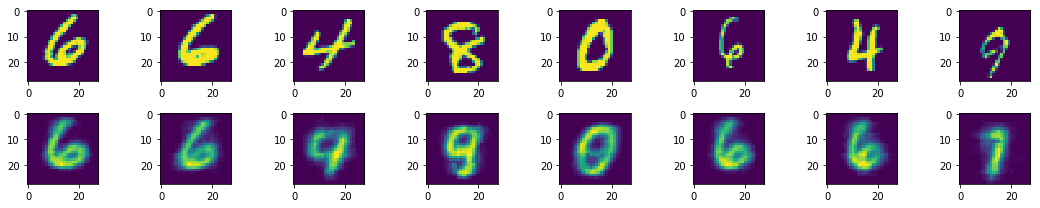

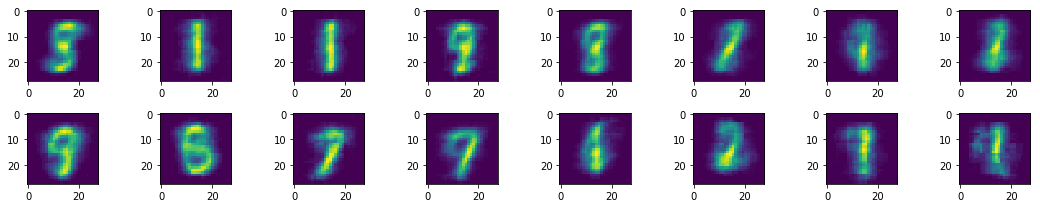

In [32]:
# net.vae = True
display_recon(g); display_gen()

In [ ]:
# net.vae = False
display_gen(mode=None)